# Scoring model for LendingClub dataset - Technical notebook

In [289]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_predict

from imblearn.over_sampling import RandomOverSampler

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

#created methods for datacleaning
# from loan_helper import data_cleaning
from loan_helper import data_converting
from loan_helper import column_description

import warnings
warnings.filterwarnings("ignore")

In [2]:
# !ls -lath LendingClub

## LendingClub data source:

https://www.lendingclub.com/info/download-data.action

In [3]:
description = pd.read_excel('LendingClub/LCDataDictionary.xlsx')

In [4]:
# from zipfile import ZipFile
# zip_file = ZipFile('LendingClub/LoanStats3d_securev1.csv.zip')
# data_lc = pd.read_csv(zip_file.open('LoanStats3d_securev1.csv'), low_memory=False, header=1)

In [290]:
#read LendingClub loan data from 2014
data_lc = pd.read_csv('LendingClub/LoanStats3c_securev1.csv', low_memory=False, header=1)
# data_lc2 = pd.read_csv('LendingClub/LoanStats3b_securev1.csv', low_memory=False, header=1)
# data_lc = pd.concat([data_lc1, data_lc2])

In [291]:
data_lc.head(2)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,36805548,NaN,10400.0,10400.0,10400.0,36 months,6.99%,321.08,A,A3,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
1,38098114,NaN,15000.0,15000.0,15000.0,60 months,12.39%,336.64,C,C1,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN


In [137]:
# data_lc['year'] = data_lc.issue_d.str[-4:].astype(int)

In [292]:
# data_lc.year.unique()

In [139]:
# data_lc = data_lc.loc[data_lc.year>2012]

In [293]:
data_lc.loan_amnt.isna().sum()

2

In [294]:
#* * * IMPORTANT * * *
#removed two rows with full NAN values
data_lc = data_lc.loc[data_lc.loan_amnt.notnull()]
data_lc.shape

(235629, 150)

## Feature selection and feature engineering

### Understanding the columns

In order to understand the columns we created a dataframe with column names, two examples, datatype, number of missing values, and the long description. The dataframe was exported to excel to make decision on columns. The result is stored in col_selection.xlsx.

In [295]:
desc = column_description(data_lc, description)

In [296]:
pd.set_option('display.max_colwidth', -1) #this allows us to see the very long description, if exceeds 50 char
desc.head(5)

,col_name,exmp1,exmp2,dtype,Description,nan_counts
0,id,37662224,36804663,object,A unique LC assigned ID for the loan listing.,0
1,member_id,NaN,NaN,float64,A unique LC assigned Id for the borrower member.,235629
2,loan_amnt,7650,23325,float64,"The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.",0
3,funded_amnt,7650,23325,float64,The total amount committed to that loan at that point in time.,0
4,funded_amnt_inv,7650,23325,float64,The total amount committed by investors for that loan at that point in time.,0


In [144]:
desc.to_excel('col_desc_2014.xlsx')

### Feauture selection

Originally the dataset contained 150 columns. When we were reducing the features in order to avoid the overfitting the model we selected features according to the following:

- Discarded columns that contained payment or collection information (47 columns)
- Discarded columns that contained information that were not available at the time of credit application
- Discarded features that require too much data processing (typically free input i.e. emp_title)
- Discarded redundant features (subgrade - grade, title - purpose)
- Discarded feauters that contain too much NAN values (mnths_since_last_delinq, mths_since_recent_bc_dlq, mths_since_recent_revol_delinq)

In [297]:
col_selection = pd.read_excel('col_selection_2014.xlsx')

In [298]:
col_selection.head()

,Unnamed: 0,col_name,exmp1,exmp2,dtype,Description,nan_counts,Decision,Cause
0,0,id,37662224,36804663,object,A unique LC assigned ID for the loan listing.,0,remove,irrelevant
1,1,member_id,NaN,NaN,float64,A unique LC assigned Id for the borrower member.,370443,remove,irrelevant
2,2,loan_amnt,7650,23325,float64,"The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.",0,keep,NaN
3,3,funded_amnt,7650,23325,float64,The total amount committed to that loan at that point in time.,0,remove,redundant
4,4,funded_amnt_inv,7650,23325,float64,The total amount committed by investors for that loan at that point in time.,0,remove,redundant


In [299]:
selected_col = col_selection.loc[col_selection.Decision == 'keep', 'col_name'].to_list()
len(selected_col)

61

In [300]:
dataset = data_lc.loc[:, selected_col]

In [301]:
dataset.shape

(235629, 61)

In [136]:
# dataset.info()

### Data cleaning and datatype converting

- emp_length column to convert numeric and missing values replaced with average
- earliest credit line: convert date to numeric (years)
- revol_util (revolving utilization) convert to numeric
- creating regions from state
- reduce categories of loan purpose
- fill null values with 0 in certain features

In [302]:
dataset = data_converting(dataset)

In [303]:
# dataset.mths_since_recent_bc_dlq.fillna(0, inplace=True)
# dataset.mths_since_recent_revol_delinq.fillna(0, inplace=True)
# dataset.emp_length.fillna(0, inplace=True)
# dataset.mo_sin_old_il_acct.fillna(0, inplace=True)

In [304]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 235629 entries, 0 to 235628
Data columns (total 61 columns):
loan_amnt                         235629 non-null float64
term                              235629 non-null object
installment                       235629 non-null float64
grade                             235629 non-null int64
emp_length                        235629 non-null float64
home_ownership                    235629 non-null object
annual_inc                        235629 non-null float64
verification_status               235629 non-null object
loan_status                       235629 non-null object
purpose                           235629 non-null object
dti                               235629 non-null float64
delinq_2yrs                       235629 non-null float64
earliest_cr_line                  235629 non-null int64
fico_range_low                    235629 non-null float64
inq_last_6mths                    235629 non-null float64
open_acc                    

### Deciding on the target feature

In [305]:
dataset.loan_status.value_counts()

Fully Paid            189555
Charged Off           41609 
Current               4215  
Late (31-120 days)    144   
In Grace Period       76    
Late (16-30 days)     30    
Name: loan_status, dtype: int64

#### Meaning of the categories
<b>Fully paid:</b> Loan has been fully repaid, either at the expiration of the 3- or 5-year year term or as a result of a prepayment.

<b>Current:</b> Loan is up to date on all outstanding payments. 

<b>In Grace Period:</b> Loan is past due but within the 15-day grace period. 

<b>Late (16-30):</b> Loan has not been current for 16 to 30 days. Learn more about the tools LendingClub has to deal with delinquent borrowers.

<b>Late (31-120):</b> Loan has not been current for 31 to 120 days. Learn more about the tools LendingClub has to deal with delinquent borrowers.

<b>Default:</b> Loan has not been current for an extended period of time. Learn more about the difference between “default” and “charge off”.

<b>Charged Off:</b> Loan for which there is no longer a reasonable expectation of further payments. Upon Charge Off, the remaining principal balance of the Note is deducted from the account balance. Learn more about the difference between “default” and “charge off”.

Sosurce: https://help.lendingclub.com/hc/en-us/articles/215488038-What-do-the-different-Note-statuses-mean-

In [306]:
pd.crosstab(columns=dataset['loan_status'], index=dataset['term'])

loan_status,Charged Off,Current,Fully Paid,In Grace Period,Late (16-30 days),Late (31-120 days)
term,,,,,,
36 months,22315,0,140255,0,0,0
60 months,19294,4215,49300,76,30,144


We decided to ignore the 'gray' categories, where there might chance to the recovery of the loan. The 'Current' category contains the 60 months term loans, removing them would panalize the long term loans by increasing the default rate within this category. 

In [307]:
#Select default categories:
dataset.loc[dataset.loan_status == 'Fully Paid', 'default'] = 0
dataset.loc[dataset.loan_status == 'Charged Off', 'default'] = 1
dataset.loc[dataset.loan_status == 'Current', 'default'] = 0

dataset = dataset.loc[dataset.default.notnull()]

In [308]:
#remove loan_status, replace with binary default
dataset = dataset.drop(columns='loan_status')

In [309]:
dataset = dataset.reset_index()
dataset = dataset.drop(columns='index')

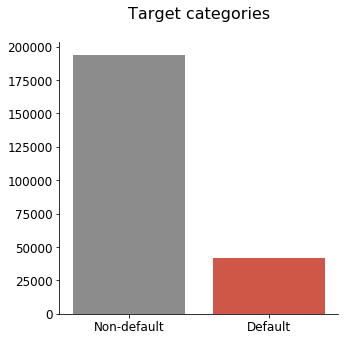

In [312]:
my_palette = ["#8c8c8c", "#e54632"]

fig1 = plt.figure(figsize=(5,5))
sns.countplot(x = 'default', data=dataset, palette=my_palette, )
ax = plt.gca()
plt.title('Target categories\n', fontsize=16)
ax.set_xticklabels(['Non-default', 'Default'])
ax.tick_params(axis='both', labelsize=12)
ax.set_xlabel('')
ax.set_ylabel('')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig1.savefig('Target_var');

In [363]:
dataset.default.sum()

41609.0

In [334]:
x_feats = dataset.columns.to_list()
x_feats.remove('default')

### Multicollinearity examination

In [142]:
# x_feats_cont =  x_feats
# x_feats_cont.remove('term')
# x_feats_cont.remove('home_ownership')
# x_feats_cont.remove('verification_status')
# x_feats_cont.remove('purpose')
# x_feats_cont.remove('region')

In [ ]:
# from statsmodels.stats.outliers_influence import variance_inflation_factor

In [146]:
# X = dataset[x_feats_cont]
# imp_vif = SimpleImputer(strategy='median', copy=True, fill_value=None)
# imp_vif.fit(X)  
# X = imp_vif.transform(X)

In [240]:
# vif = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
# list(zip(x_feats_cont, vif))

In [193]:
# x_feats = ['revol_util','revol_bal','fico_range_low','grade','installment','loan_amnt','emp_length','annual_inc','delinq_2yrs','dti','delinq_2yrs','inq_last_6mths',
#            'pub_rec','collections_12_mths_ex_med', 'tot_coll_amt', 'total_rev_hi_lim','acc_open_past_24mths',
#            'avg_cur_bal','chargeoff_within_12_mths','delinq_amnt', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl',
#           'mths_since_recent_bc', 'mths_since_recent_inq','num_accts_ever_120_pd','num_tl_120dpd_2m',
#           'num_tl_30dpd','num_tl_90g_dpd_24m', 'num_tl_op_past_12m','percent_bc_gt_75', 'pub_rec_bankruptcies',
#           'tax_liens']
# x_feats += ['term','home_ownership','verification_status','purpose','region']

In [241]:
# x_feats

In [252]:
# x_feats.remove('level_0')

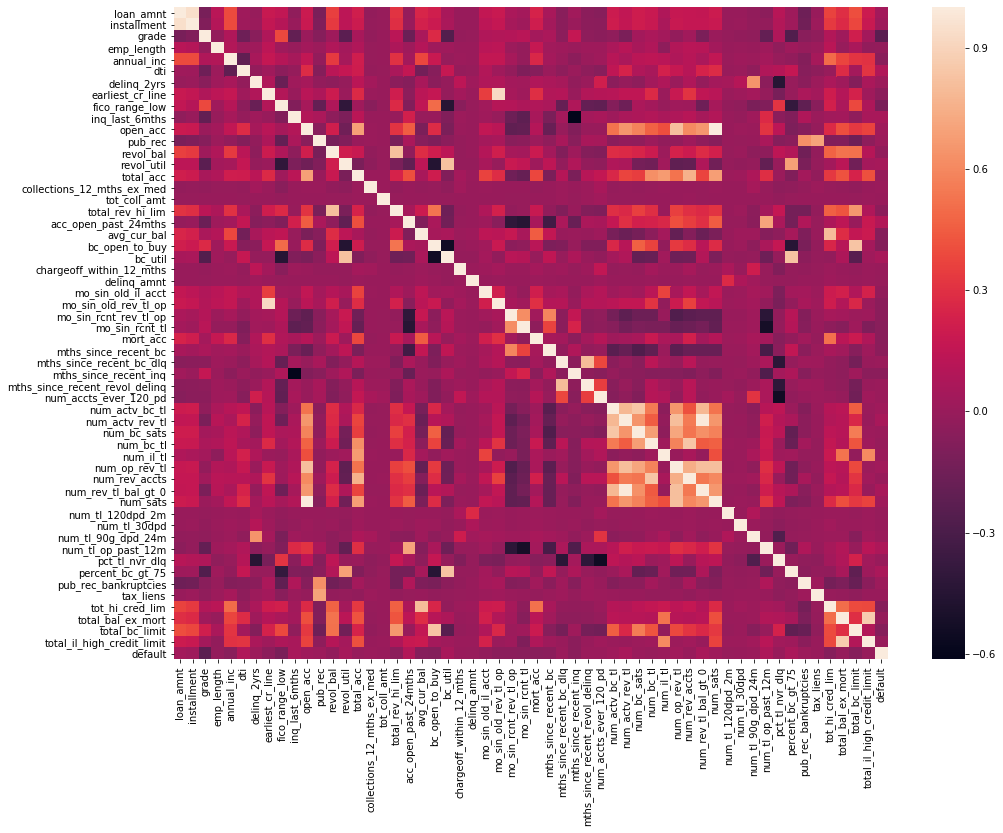

In [316]:
corr = dataset.corr()
plt.figure(figsize=(16,12))
sns.heatmap(corr);
# corr.style.background_gradient(cmap='coolwarm').set_precision(2)

In [319]:
corr_df = []
for i in range(corr.shape[1]):
    for j in range(i+1, corr.shape[1]):
        if corr.iat[i,j]>0.8:
            corr_df.append([corr.index[i], corr.columns[j], corr.iat[i,j]])
corr_df = pd.DataFrame(corr_df, columns = ['col_name1','col_name2', 'r_square'])

In [320]:
corr_df

,col_name1,col_name2,r_square
0,loan_amnt,installment,0.947946
1,earliest_cr_line,mo_sin_old_rev_tl_op,0.923295
2,open_acc,num_op_rev_tl,0.812278
3,open_acc,num_sats,0.998641
4,revol_bal,total_rev_hi_lim,0.816803
5,revol_util,bc_util,0.818250
6,avg_cur_bal,tot_hi_cred_lim,0.803073
7,bc_open_to_buy,total_bc_limit,0.833603
8,bc_util,percent_bc_gt_75,0.828988
9,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,0.804537


In [332]:
remove_col = ['installment', 'mo_sin_old_rev_tl_op', 'num_sats', 'revol_bal', 'bc_util', 'num_bc_tl',
             'avg_cur_bal', 'total_bc_limit', 'num_actv_bc_tl', 'num_rev_tl_bal_gt_0', 'total_bal_ex_mort']

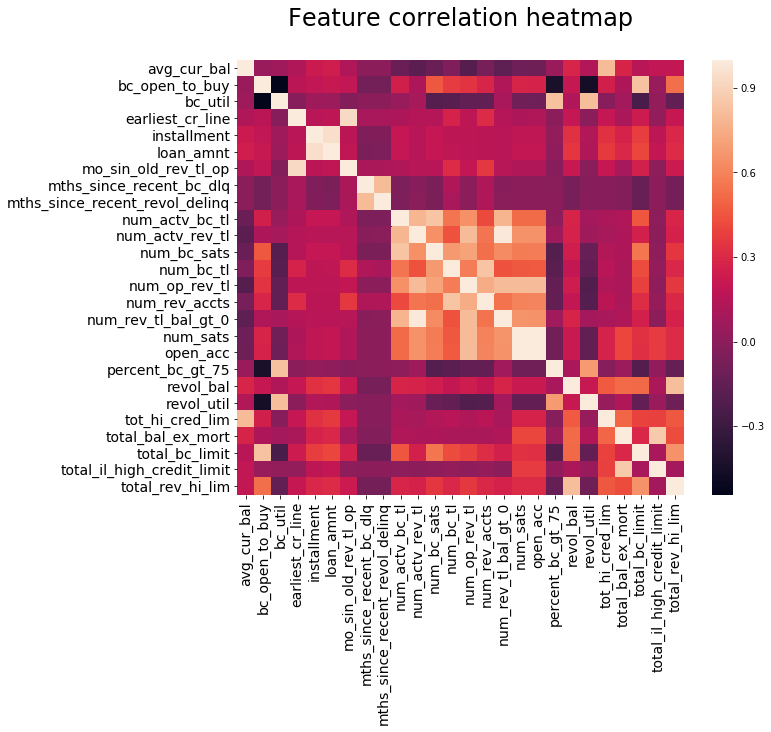

In [328]:
corr_columns = list(set(corr_df.col_name1.unique()) | set(corr_df.col_name2.unique()))
corr_columns.sort()
corr2 = dataset.loc[:,corr_columns].corr()
fig2 = plt.figure(figsize=(10,8))
ax = plt.gca()
ax.tick_params(axis='both', labelsize=14)
plt.title('Feature correlation heatmap\n', fontsize = 24)
sns.heatmap(corr2)
fig2.savefig('Feature_corr2');

In [335]:
[x_feats.remove(col) for col in remove_col]

[None, None, None, None, None, None, None, None, None, None, None]

In [336]:
len(x_feats)

49

## Preparing dataset for modeling

In [338]:
X = pd.get_dummies(dataset[x_feats], drop_first=True)

In [339]:
y = dataset.default

In [340]:
y.value_counts()

0.0    193770
1.0    41609 
Name: default, dtype: int64

In [341]:
X.head()

,loan_amnt,grade,emp_length,annual_inc,dti,delinq_2yrs,earliest_cr_line,fico_range_low,inq_last_6mths,open_acc,...,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_small_business,region_NE,region_SE,region_SW,region_W
0,10400.0,7,8.0,58000.0,14.92,0.0,26,710.0,2.0,17.0,...,0,0,0,0,0,0,0,0,0,1
1,15000.0,5,10.0,78000.0,12.03,0.0,21,750.0,0.0,6.0,...,0,0,0,0,0,0,0,1,0,0
2,9600.0,5,10.0,69000.0,25.81,0.0,23,680.0,0.0,12.0,...,0,0,0,0,0,0,1,0,0,0
3,12800.0,4,10.0,125000.0,8.31,1.0,15,665.0,0.0,8.0,...,0,0,0,0,0,0,0,0,0,1
4,21425.0,4,6.0,63800.0,18.49,0.0,12,685.0,0.0,10.0,...,0,0,0,0,0,0,0,0,0,0


In [342]:
X.shape

(235379, 63)

In [344]:
# X.columns

### Train-Test Split

In [345]:
#'Stratify=y' provide us the same ratio in the target variable then it was in the original dataset 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10, stratify=y) #25%

In [346]:
y_train.mean()

0.1767761451051922

In [347]:
y_test.mean()

0.17676947914011387

### Further datacleaning separately for train and test



- annual_inc: in case of annual income we had to handle extreme values (there are many strategies, we were choosing truncating the extreme values to the value of the 99 quantile)
- imputing mean values in place of missing values


In [348]:
imp = SimpleImputer(strategy='median', copy=True, fill_value=None)
imp.fit(X_train)  

X_train_imp = imp.transform(X_train)      
X_test_imp = imp.transform(X_test)

In [349]:
income_trunc = X_train.annual_inc.quantile(q=0.99)
income_trunc

250000.0

In [350]:
b_train = X_train_imp > income_trunc
b_test = X_test_imp > income_trunc

In [351]:
X_train_imp[b_train] = income_trunc
X_test_imp[b_test] = income_trunc

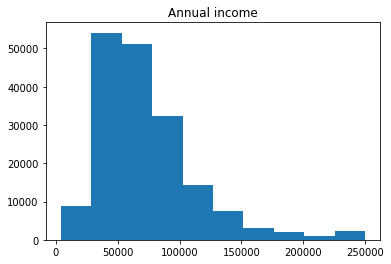

In [352]:
plt.hist(X_train_imp[:,3])
plt.title('Annual income');

### Scaling

The following scaling method assures that the variables of X_train are within a 0-1 range

In [ ]:
# scaler = MinMaxScaler()

The following scaling method robost to outliers

In [ ]:
# scaler = RobustScaler()

The most standard scaling method

In [353]:
scaler = StandardScaler()
scaler.fit(X_train_imp)
X_train_scaled = scaler.transform(X_train_imp)
X_test_scaled = scaler.transform(X_test_imp)

# Objective: Increase predictibility of loan defaults from actual default 

#### Maximize the F1 score, find the optimal cut-off

In [354]:
def get_metric(y_train, y_probability):
    '''
    inputs: y_train values and from the trained model the y probabilities for default
    output: maximized F1 score, cut-off and the corresponding y_hat
    '''
    y = 0
    F1_score = 0
    cut_off = 0
    for cutoff in np.linspace(0,1,101):
        y_hat = (y_probability > cutoff) * 1
        f1 = f1_score(y_train, y_hat)
        if f1> F1_score:
            F1_score = f1
            cut_off = cutoff
            y = y_hat
    
    print('Recall:', recall_score(y_train, y))
    print('Precision:', precision_score(y_train, y))
    print('F1_score:', F1_score)
    print('Cut_off:', cut_off)
    
    conf_matrix = pd.DataFrame(confusion_matrix(y_train, y),
                                    index=['actual 0', 'actual 1'],
                                    columns=['predicted 0', 'predicted 1'])
    
    return conf_matrix

 ## Model Selection - Logistic regression

### Baseline: vanilla logistic regression w/o imbalance strategy

In [355]:
# Vanilla regression
logreg_vanilla = LogisticRegression(C=1e9, solver='liblinear', max_iter=200)

model_vanilla = logreg_vanilla.fit(X_train_scaled, y_train)

y_probability = model_vanilla.predict_proba(X_train_scaled)[:,1]

get_metric(y_train, y_probability)

Recall: 0.6375172236998109
Precision: 0.2830094739537398
F1_score: 0.3920003940692577
Cut_off: 0.18


,predicted 0,predicted 1
actual 0,94924,50403
actual 1,11312,19895


In [356]:
p, r, t = precision_recall_curve(y_train, model_vanilla.decision_function(X_train_scaled))

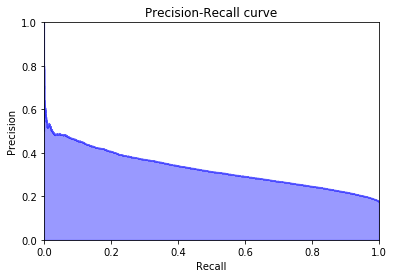

In [358]:
from inspect import signature
step_kwargs = ({'step': 'post'} if 'step' in signature(plt.fill_between).parameters else {})
plt.step(r, p, color='b', alpha=0.4, where='post')
plt.fill_between(r, p, color='b', alpha=0.4, **step_kwargs)
plt.xlabel('precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1])
plt.xlim([0.0, 1])
plt.title('Precision-Recall curve');

In [ ]:
#SMOTE
#Logistic regression inbuilt class weight
#sklearn.
#imblearn.over_sampling.SMOTE
#RandomOverSampler
#Undersampling?
#C values influence to precision
#Different stragegy on precision


### Lasso regression with different C values (w/o imbalance strategy)

In [359]:
C_values = [0.01, 0.1, 1, 10, 100, 1000, 10000]  # low value means high l1 penalty on coefficients

for C in C_values:
    logreg_l1 = LogisticRegression(C=C, penalty='l1',
                                   solver='liblinear',
                                   max_iter=200)
    print('-'*40,f'\nLasso regression with C = {C}')
    model_l1 = logreg_l1.fit(X_train_scaled, y_train)
    y_probability = model_l1.predict_proba(X_train_scaled)[:,1]
    print(get_metric(y_train, y_probability))


---------------------------------------- 
Lasso regression with C = 0.01
Recall: 0.6027814272438876
Precision: 0.2897119975358078
F1_score: 0.39133736230587596
Cut_off: 0.19
          predicted 0  predicted 1
actual 0  99208        46119      
actual 1  12396        18811      
---------------------------------------- 
Lasso regression with C = 0.1
Recall: 0.6015317076296984
Precision: 0.2906017307305293
F1_score: 0.39188342866686154
Cut_off: 0.19
          predicted 0  predicted 1
actual 0  99502        45825      
actual 1  12435        18772      
---------------------------------------- 
Lasso regression with C = 1
Recall: 0.6375492677924824
Precision: 0.28297539468069977
F1_score: 0.3919737580897781
Cut_off: 0.18
          predicted 0  predicted 1
actual 0  94913        50414      
actual 1  11311        19896      
---------------------------------------- 
Lasso regression with C = 10
Recall: 0.637581311885154
Precision: 0.2830177944042217
F1_score: 0.39202049059205984
Cut_off: 0

In [394]:

# np.set_printoptions(formatter = {'float': '{:.5f}'.format})
# model_l1.coef_

#### Lasso regression with C=100

In [310]:
# logreg_l1 = LogisticRegression(C=1, penalty='l1', solver='liblinear', max_iter=200)
# model_l1 = logreg_l1.fit(X_train_scaled, y_train)

In [322]:
# coef_df = pd.DataFrame([X.columns, model_l1.coef_.tolist()[0]]).T

In [328]:
# coef_df.columns = ['col_name', 'coef']

In [330]:
# coef_df['abs'] = coef_df.coef.abs()

In [393]:
# coef_df.loc[coef_df['abs']>0.1]

### Ridge regression with different C values (w/o imbalance strategy)

In [361]:
C_values = [0.01, 0.1, 1, 10, 100, 1000, 10000]  # low value means high l1 penalty on coefficients

for C in C_values:
    logreg_l2 = LogisticRegression(C=C, penalty='l2',
                                   solver='newton-cg',
                                   max_iter=200)
    
    print('-'*40,f'\nRidge regression with C = {C}')
    model_l2 = logreg_l2.fit(X_train_scaled, y_train)
    y_probability = model_l2.predict_proba(X_train_scaled)[:,1]
    print(get_metric(y_train, y_probability))

---------------------------------------- 
Ridge regression with C = 0.01
Recall: 0.6378056205338546
Precision: 0.2829724619343465
F1_score: 0.3920193803793355
Cut_off: 0.18
          predicted 0  predicted 1
actual 0  94892        50435      
actual 1  11303        19904      
---------------------------------------- 
Ridge regression with C = 0.1
Recall: 0.6374851796071395
Precision: 0.282934876907542
F1_score: 0.3919227738376675
Cut_off: 0.18
          predicted 0  predicted 1
actual 0  94908        50419      
actual 1  11313        19894      
---------------------------------------- 
Ridge regression with C = 1
Recall: 0.637581311885154
Precision: 0.2830137687756031
F1_score: 0.39201662873974247
Cut_off: 0.18
          predicted 0  predicted 1
actual 0  94920        50407      
actual 1  11310        19897      
---------------------------------------- 
Ridge regression with C = 10
Recall: 0.6375172236998109
Precision: 0.2830134998648591
F1_score: 0.3920042559899117
Cut_off: 0.18


### Cross-Validation (w/o imbalance strategy)

In [276]:
cv = StratifiedKFold(n_splits= 5, random_state=1000, shuffle=True)

#### Vanilla

In [277]:
lr_vanilla = LogisticRegression(C=1e9,
                                solver='newton-cg',
                                max_iter=200)


cv_vanilla = cross_validate(estimator=lr_vanilla,
                            X=X_train_scaled, y=y_train,
                            cv=cv,
                            n_jobs=-1,
                            return_train_score=True)

In [278]:
y_probability = cross_val_predict(lr_vanilla, X_train_scaled, y_train, cv=cv, method='predict_proba')[:,1]
get_metric(y_train, y_probability)

Recall: 0.5683632415863082
Precision: 0.286351644108878
F1_score: 0.38083284005733886
Cut_off: 0.19


,predicted 0,predicted 1
actual 0,164125,66542
actual 1,20277,26700


#### Ridge

In [279]:
l2_reg = LogisticRegression(C=1,
                            solver='newton-cg',
                            penalty='l2',
                            max_iter=200)

cv_l2 = cross_validate(estimator=l2_reg, X=X_train_scaled, y=y_train,
                       cv=cv,
                       n_jobs=-1,
                       return_estimator=True,
                       return_train_score=True)

In [280]:
y_probability = cross_val_predict(l2_reg, X_train_scaled, y_train, cv=cv, method='predict_proba')[:,1]
get_metric(y_train, y_probability)

Recall: 0.5683845285991017
Precision: 0.2863623688895562
F1_score: 0.3808471034595882
Cut_off: 0.19


,predicted 0,predicted 1
actual 0,164126,66541
actual 1,20276,26701


#### Lasso

In [281]:
l1_reg = LogisticRegression(C=1,
                            solver='saga',
                            penalty='l1',
                            max_iter=200)
cv_l1 = cross_validate(estimator=l1_reg, X=X_train_scaled, y=y_train,
                       cv=cv,
                       n_jobs=-1,
                       return_estimator=True,
                       return_train_score=True)

In [282]:
y_probability = cross_val_predict(l1_reg, X_train_scaled, y_train, cv=cv, method='predict_proba')[:,1]
get_metric(y_train, y_probability)

Recall: 0.5683845285991017
Precision: 0.2863592977488927
F1_score: 0.3808443873912423
Cut_off: 0.19


,predicted 0,predicted 1
actual 0,164125,66542
actual 1,20276,26701


## IMBALANCE STRATEGY: RANDOM OVERSAMPLING

In [283]:
ros = RandomOverSampler(random_state=42)
X_train_resamp, y_train_resamp = ros.fit_resample(X_train_scaled, y_train)

In [284]:
y_train_resamp.mean()

0.5

### Baseline: vanilla logistic regression (random oversampling)

In [288]:
logreg_vanilla = LogisticRegression(C=1e9, solver='liblinear', max_iter=200)
model_vanilla = logreg_vanilla.fit(X_train_resamp, y_train_resamp)

y_probability = model_vanilla.predict_proba(X_train_scaled)[:,1]
get_metric(y_train, y_probability)

Recall: 0.5599548715328778
Precision: 0.28888815673871027
F1_score: 0.3811407417066933
Cut_off: 0.54


,predicted 0,predicted 1
actual 0,165916,64751
actual 1,20672,26305


### Lasso regression with different C values (random oversampling)

In [286]:
C_values = [0.01, 0.1, 1, 10, 100, 1000, 10000]  # low value means high l1 penalty on coefficients

for C in C_values:
    logreg_l1 = LogisticRegression(C=C, penalty='l1',
                                   solver='liblinear',
                                   max_iter=200)
    print('-'*40,f'\nLasso regression with C = {C}')
    model_l1 = logreg_l1.fit(X_train_resamp, y_train_resamp)
    
    y_probability = model_l1.predict_proba(X_train_scaled)[:,1]
    get_metric(y_train, y_probability)

---------------------------------------- 
Lasso regression with C = 0.01
Recall: 0.5809864401728505
Precision: 0.2835165063469969
F1_score: 0.38107272257632135
Cut_off: 0.53
---------------------------------------- 
Lasso regression with C = 0.1
Recall: 0.5598058624433233
Precision: 0.28887473087569754
F1_score: 0.3810945345728301
Cut_off: 0.54
---------------------------------------- 
Lasso regression with C = 1
Recall: 0.5598910104944973
Precision: 0.28886155468183716
F1_score: 0.3811027957487811
Cut_off: 0.54
---------------------------------------- 
Lasso regression with C = 10
Recall: 0.5599335845200843
Precision: 0.28887082958114607
F1_score: 0.3811207302495744
Cut_off: 0.54
---------------------------------------- 
Lasso regression with C = 100
Recall: 0.5598271494561168
Precision: 0.28880323296215765
F1_score: 0.3810372430979651
Cut_off: 0.54
---------------------------------------- 
Lasso regression with C = 1000
Recall: 0.5598910104944973
Precision: 0.28887424492037345
F1_sco

### Ridge regression with different C values (random oversampling)

In [ ]:
C_values = [0.01, 0.1, 1, 10, 100, 1000, 10000]  # low value means high l1 penalty on coefficients

for C in C_values:
    logreg_l2 = LogisticRegression(C=C, penalty='l2',
                                   solver='newton-cg',
                                   max_iter=200)
    
    print('-'*40,f'\nRidge regression with C = {C}')
    model_l2 = logreg_l2.fit(X_train_resamp, y_train_resamp)
    
    y_probability = model_l2.predict_proba(X_train_scaled)[:,1]
    get_metric(y_train, y_probability)

### Cross-Validation (random oversampling)

#### Baseline: Vanilla

In [ ]:
lr_vanilla = LogisticRegression(C=1e9,
                                solver='newton-cg',
                                max_iter=200)

cv_vanilla = cross_validate(estimator=lr_vanilla,
                            X=X_train_resamp, y=y_train_resamp,
                            cv=cv,
                            n_jobs=-1,
                            return_train_score=True)

In [ ]:
y_probability = cross_val_predict(lr_vanilla, X_train_scaled, y_train, cv=cv, method='predict_proba')[:,1]
get_metric(y_train, y_probability)

#### Ridge

In [ ]:
l2_reg = LogisticRegression(C=1,
                            solver='newton-cg',
                            penalty='l2',
                            max_iter=200)

cv_l2 = cross_validate(estimator=l2_reg, X=X_train_scaled, y=y_train,
                       cv=cv,
                       n_jobs=-1,
                       return_estimator=True,
                       return_train_score=True)

In [ ]:
y_probability = cross_val_predict(l2_reg, X_train_scaled, y_train, cv=cv, method='predict_proba')[:,1]
get_metric(y_train, y_probability)

#### Lasso

In [ ]:
l1_reg = LogisticRegression(C=1,
                            solver='saga',
                            penalty='l1',
                            max_iter=200)
cv_l1 = cross_validate(estimator=l1_reg, X=X_train_scaled, y=y_train,
                       cv=cv,
                       n_jobs=-1,
                       return_estimator=True,
                       return_train_score=True)

In [ ]:
y_probability = cross_val_predict(l1_reg, X_train_scaled, y_train, cv=cv, method='predict_proba')[:,1]
get_metric(y_train, y_probability)

## IMBALANCE STRATEGY: SMOTE

In [141]:
from imblearn.over_sampling import SMOTE